## Importations

In [1]:
# Run Keras on CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"        # -1 if CPU

In [2]:
# Importations
import sys
sys.path.append('utils')

from configtf2 import *
import CPutils_tf2
%matplotlib inline

In [3]:
tf.test.gpu_device_name()

''

# Utils

In [4]:
# Plot all maps in squares
def plot_filters(feature_maps, 
                 size=(20,20),
                 cmap=None,
                 save=False,
                 OUTPATH='',
                 filename='featureMap'):
    square = np.sqrt(feature_maps.shape[-1]).astype(np.int)
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])

            # plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, ix-1], cmap=cmap)
            ix += 1

    # show the figure
    plt.rcParams['figure.figsize'] = size[0], size[1]
    
    # Save
    if save:
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPATH, filename + '.pdf'), dpi=300)
    
    plt.show()  

In [5]:
# Backend importation (for custo metrics if wanted)
import tensorflow.keras.backend as K

# Custom metrics
def specificity(y_pred, y_true):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# One class accuracy
INTERESTING_CLASS_ID = 1  # Choose the class of interest
def single_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, INTERESTING_CLASS_ID), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

# Loss function 
def specificity_loss_wrapper():
    """A wrapper to create and return a function which computes the specificity loss, as (1 - specificity)

    """
    # Define the function for your loss
    def specificity_loss(y_true, y_pred):
        return 1.0 - specificity(y_true, y_pred)

    return specificity_loss    # we return this function object

# CONV visualization

In [6]:
# Model Path
PRE_TRAINED = os.path.join('..', 'pretrained_models')
DATA_PATH = os.path.join('..', 'data', 'dataset')

In [7]:
# Model from scratch and then load weights
from nets_tf2.firenet import FireNet
dims = (38, 31, 1)
model = FireNet.build_model(width=dims[0], height=dims[1], depth=dims[2], classes=2)
model.load_weights(os.path.join(PRE_TRAINED, 'ROS_ORtest_default_final_model_weights.h5'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 31, 38, 32)        73        
_________________________________________________________________
activation (Activation)      (None, 31, 38, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 38, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 19, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 19, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 15, 19, 64)        2400      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 19, 64)        0

# Example: Conv 1

In [8]:
# Redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_input (Inpu [(None, 31, 38, 1)]       0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 31, 38, 32)        73        
_________________________________________________________________
activation (Activation)      (None, 31, 38, 32)        0         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


## Select the image

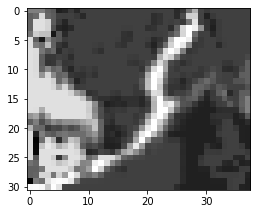

In [9]:
# load the image with the required shape
img = cv2.imread(os.path.join(DATA_PATH, '1_11212.png'), 0)
img = cv2.resize(img, (38, 31))
img = np.array(img)
plt.rcParams['figure.figsize'] = 4,4
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=-1)

# prepare the image (e.g. scale pixel values for the vgg)
img = img / 255.

In [10]:
# Check shape (added batch dimension and channel - grayscale)
img.shape

(1, 31, 38, 1)

In [11]:
# Get maps
feature_maps = model.predict(img)
len(feature_maps)

1

## Plot 

<Figure size 288x288 with 0 Axes>

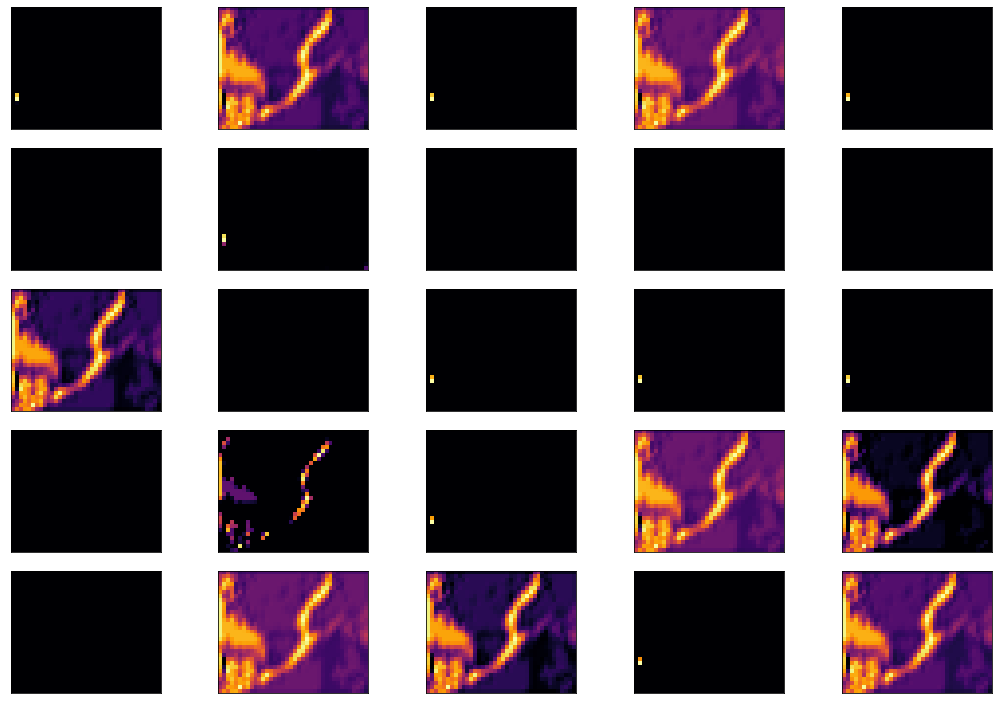

In [12]:
# Plot all maps in an 8x8 squares
CPutils_tf2.plt_style()
plot_filters(feature_maps, size=(30,30), cmap='inferno', 
             save=True, OUTPATH='', filename='featureMap')

# All Layers

In [13]:
# Re-load model
# Model from scratch
from nets_tf2.cancernet import CancerNet
dims = (38, 31, 1)
model = CancerNet.build(width=dims[0], height=dims[1], depth=dims[2], classes=2)
model.load_weights(os.path.join(PRE_TRAINED, 'ROS_ORtest_default_final_model_weights.h5'))

# Redefine model to output right after each conv layer
ixs = [0,5,8,13,16,19]                                 # ID of layers to select
outputs = [model.layers[i+1].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_6_input (In [(None, 31, 38, 1)]       0         
_________________________________________________________________
separable_conv2d_6 (Separabl (None, 31, 38, 32)        73        
_________________________________________________________________
activation_8 (Activation)    (None, 31, 38, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 31, 38, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 19, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 19, 32)        0         
_________________________________________________________________
separable_conv2d_7 (Separabl (None, 15, 19, 64)        2400

In [14]:
# See layers 
for idx, layer in enumerate(model.layers):
    print(idx, "-", layer.__class__.__name__)

0 - InputLayer
1 - SeparableConv2D
2 - Activation
3 - BatchNormalization
4 - MaxPooling2D
5 - Dropout
6 - SeparableConv2D
7 - Activation
8 - BatchNormalization
9 - SeparableConv2D
10 - Activation
11 - BatchNormalization
12 - MaxPooling2D
13 - Dropout
14 - SeparableConv2D
15 - Activation
16 - BatchNormalization
17 - SeparableConv2D
18 - Activation
19 - BatchNormalization
20 - SeparableConv2D
21 - Activation


In [15]:
# Check outputs
outputs

[<KerasTensor: shape=(None, 31, 38, 32) dtype=float32 (created by layer 'activation_8')>,
 <KerasTensor: shape=(None, 15, 19, 64) dtype=float32 (created by layer 'activation_9')>,
 <KerasTensor: shape=(None, 15, 19, 64) dtype=float32 (created by layer 'activation_10')>,
 <KerasTensor: shape=(None, 7, 9, 128) dtype=float32 (created by layer 'activation_11')>,
 <KerasTensor: shape=(None, 7, 9, 128) dtype=float32 (created by layer 'activation_12')>,
 <KerasTensor: shape=(None, 7, 9, 128) dtype=float32 (created by layer 'activation_13')>]

In [16]:
# Get maps
feature_maps = model.predict(img)
len(feature_maps)

6

<Figure size 2160x2160 with 0 Axes>

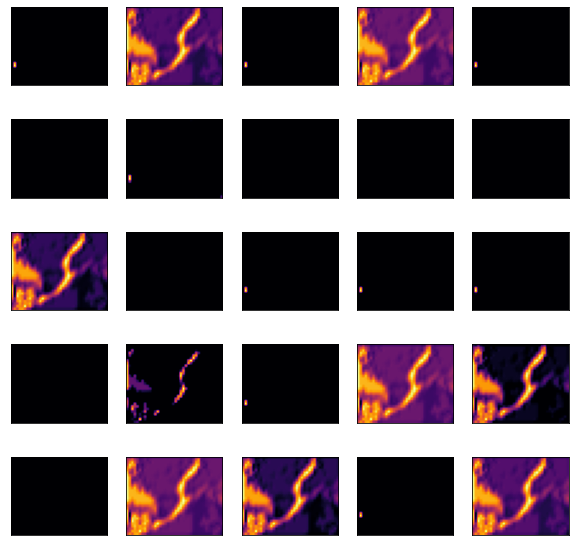

<Figure size 1440x1440 with 0 Axes>

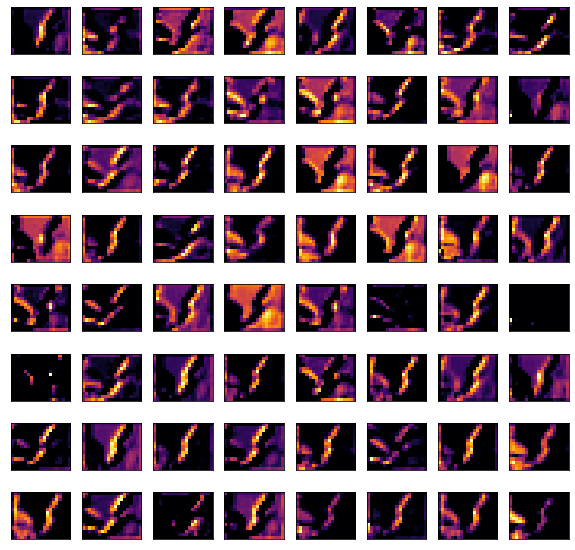

<Figure size 1440x1440 with 0 Axes>

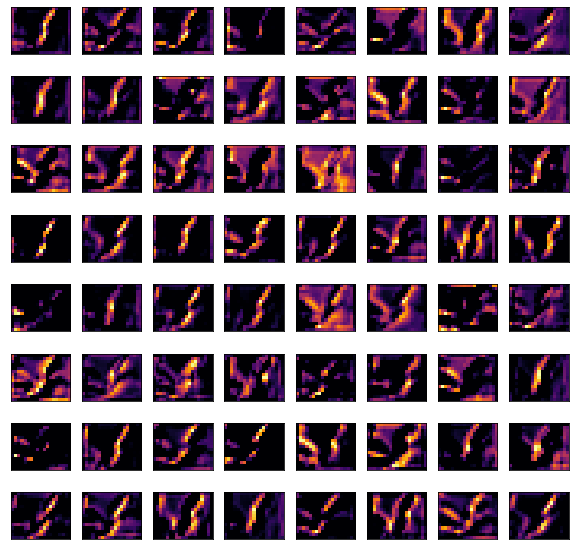

<Figure size 1440x1440 with 0 Axes>

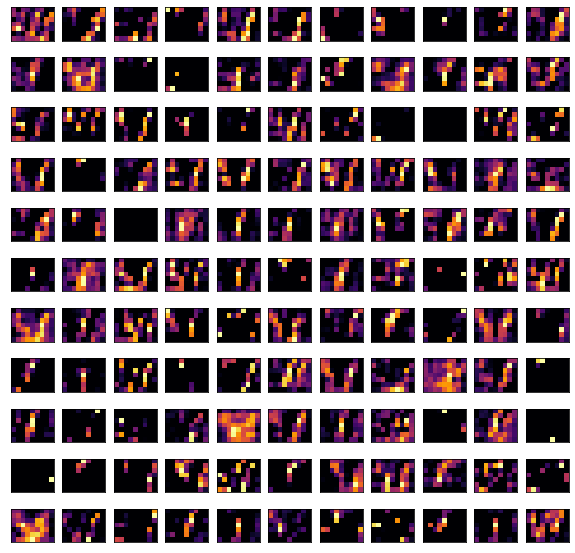

<Figure size 1440x1440 with 0 Axes>

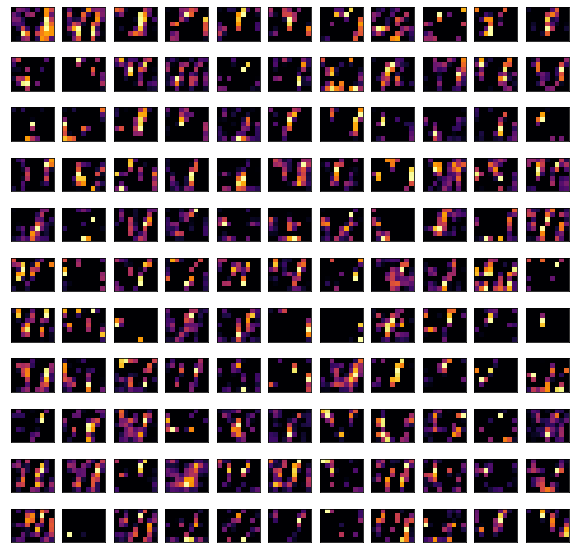

<Figure size 1440x1440 with 0 Axes>

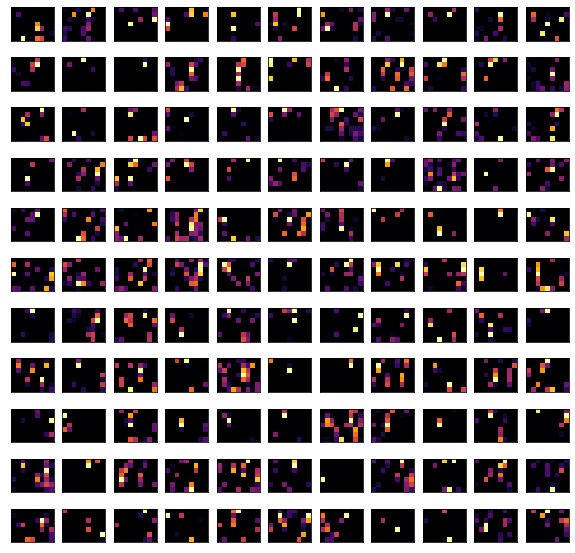

In [17]:
# Plot all maps (inferno)
for feature_map in feature_maps:
    CPutils_tf2.plt_style(figsize=(10,10))
    plot_filters(feature_map, cmap='inferno')

<Figure size 1440x1440 with 0 Axes>

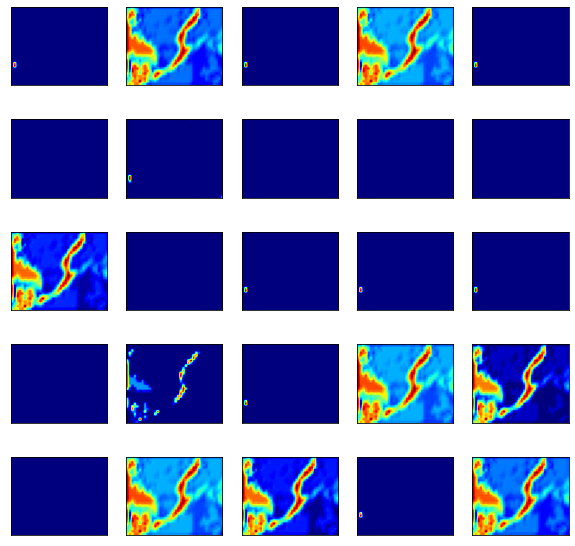

<Figure size 1440x1440 with 0 Axes>

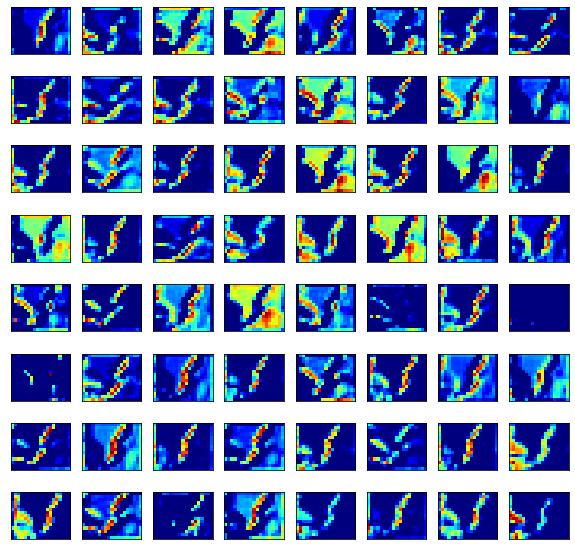

<Figure size 1440x1440 with 0 Axes>

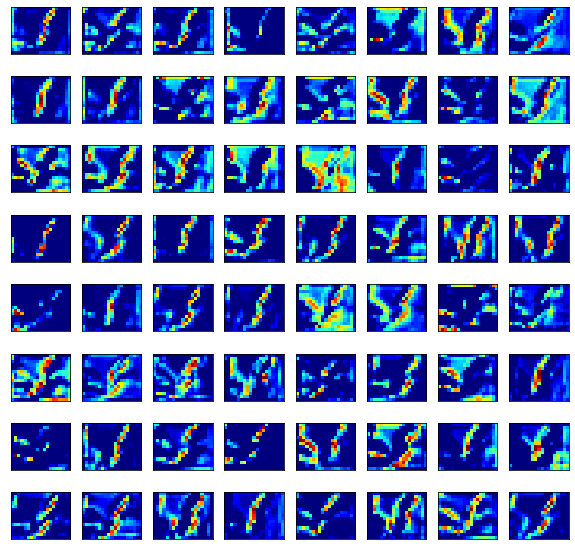

<Figure size 1440x1440 with 0 Axes>

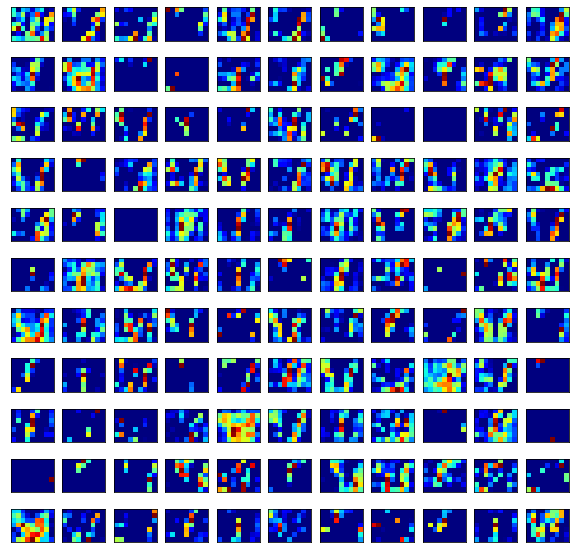

<Figure size 1440x1440 with 0 Axes>

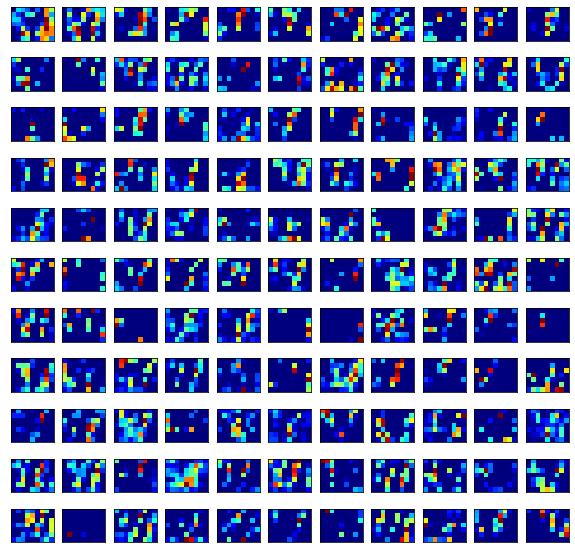

<Figure size 1440x1440 with 0 Axes>

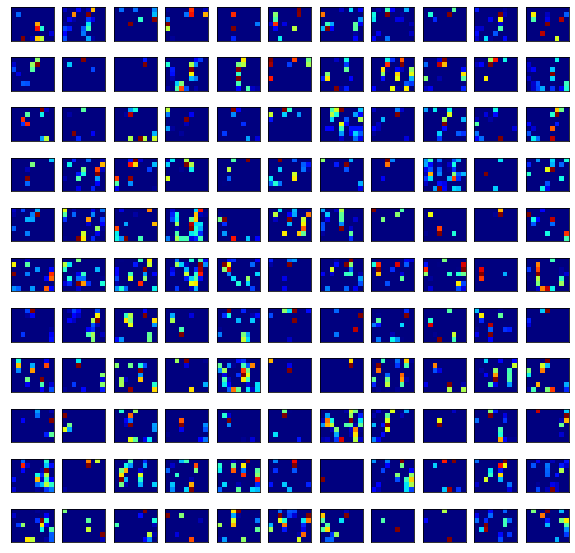

In [18]:
# Plot all maps (jet)
for feature_map in feature_maps:
    CPutils_tf2.plt_style(figsize=(10,10))
    plot_filters(feature_map, cmap='jet')

# Full pipeline
- Load image to pass
- Load model
- Get conv layers

In [19]:
# load the image with the required shape
def load_image(DATA_PATH, filename, size=(38,31)):
    img = cv2.imread(os.path.join(DATA_PATH, filename), 0)
    img = cv2.resize(img, size)
    img = np.array(img)
    plt.rcParams['figure.figsize'] = 4,4
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # expand dimensions so that it represents a single 'sample'
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)

    # prepare the image (e.g. scale pixel values for the vgg)
    img = img / 255.
    
    # return image
    return img

In [20]:
# Load the model and select the layers to output (ids)
def load_model(PRE_TRAINED_PATH, 
               dims=(38,31,1),
               weightsFile='ROS_ORtest_default_final_model_weights.h5',
               ix=[0,5,8,13,16,19]):
    # Model from scratch and then load weights
    from nets_tf2.cancernet import CancerNet
    model = CancerNet.build(width=dims[0], height=dims[1], depth=dims[2], classes=2)
    model.load_weights(os.path.join(PRE_TRAINED_PATH, weightsFile))

    # Redefine model to output right after each conv layer
    outputs = [model.layers[i+1].output for i in ixs]
    model = Model(inputs=model.inputs, outputs=outputs)
    
    return model

In [21]:
# Printout model layers
def check_layers(model):
    # See layers 
    for idx, layer in enumerate(model.layers):
        print(idx, "-", layer.__class__.__name__)

In [22]:
# Full pipeline
def output_filters(IMG_PATH=os.path.join('..', 'data', 'dataset'), 
                   imgname='0_2.png', 
                   imgsize=(38,31), 
                   PRE_TRAINED_PATH=os.path.join('..', 'pretrained_models', 'gray_topology', 'ROS'), 
                   weightsFile='ROS_ORtest_default_final_model_weights.h5',
                   modeldims=(38,31,1), 
                   layersidx=[0],
                   figsize=(10,10),
                   save=True,
                   OUTPATH='',
                   filename='featureMap',
                   cmap='inferno'):
    # Load image
    img = load_image(DATA_PATH=IMG_PATH, 
                     filename=imgname,
                     size=imgsize)
    
    # Load model
    model = load_model(PRE_TRAINED_PATH=PRE_TRAINED_PATH,
                       dims=modeldims,
                       weightsFile=weightsFile,
                       ix=layersidx)
    
    # Get maps
    feature_maps = model.predict(img)
    
    # Plot all maps
    for idx,feature_map in enumerate(feature_maps):
        CPutils_tf2.plt_style(figsize=figsize)
        plot_filters(feature_map, cmap=cmap, save=save, OUTPATH=OUTPATH, filename=filename + '_' + str(idx))

## No Fire

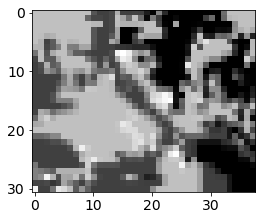

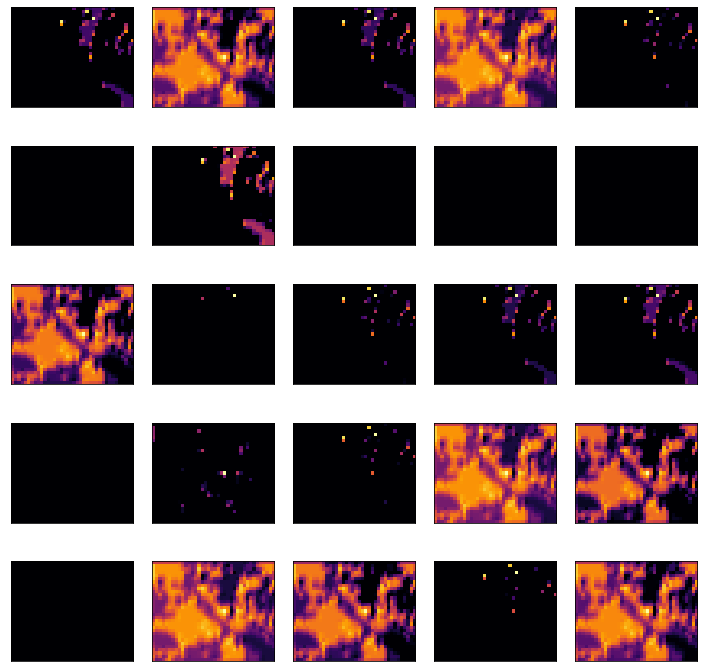

<Figure size 1440x1440 with 0 Axes>

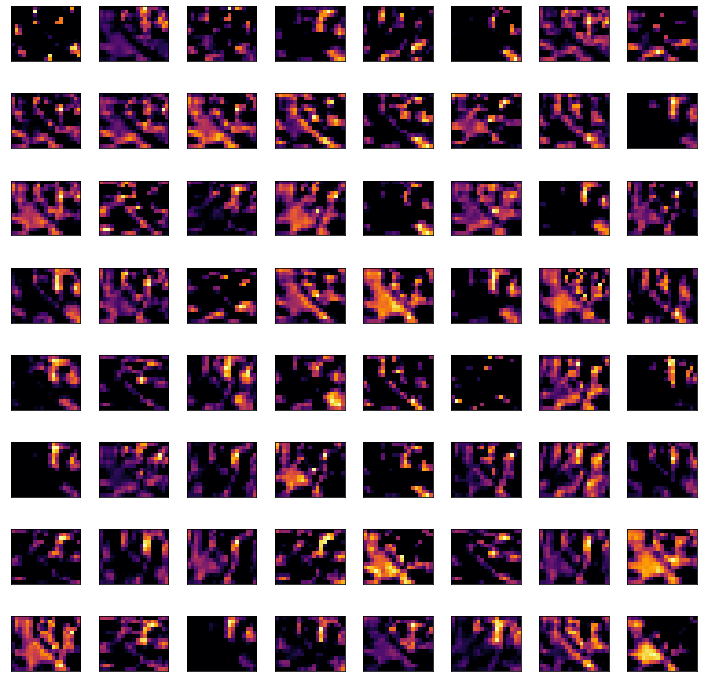

<Figure size 1440x1440 with 0 Axes>

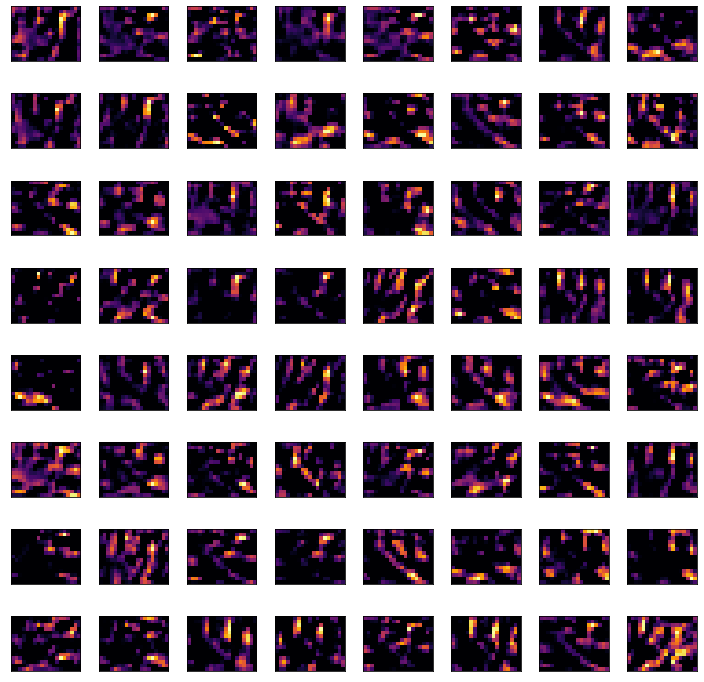

<Figure size 1440x1440 with 0 Axes>

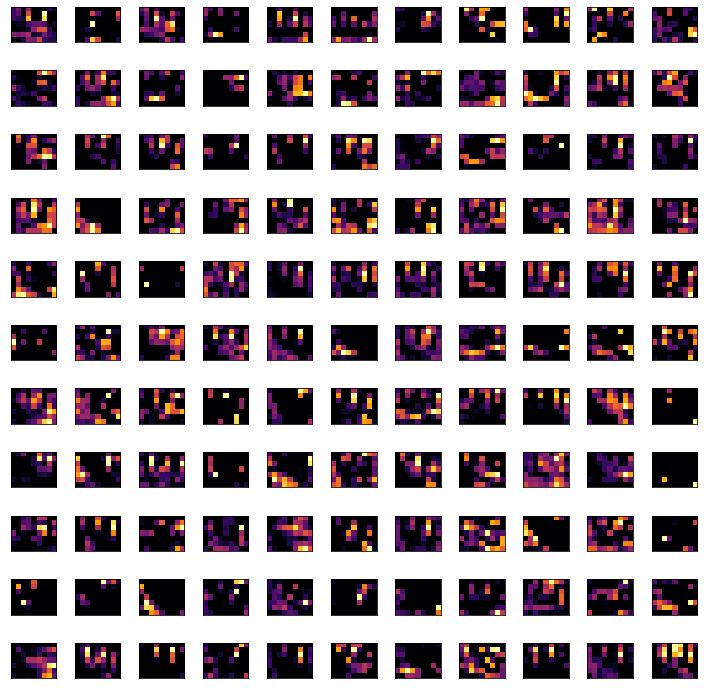

<Figure size 1440x1440 with 0 Axes>

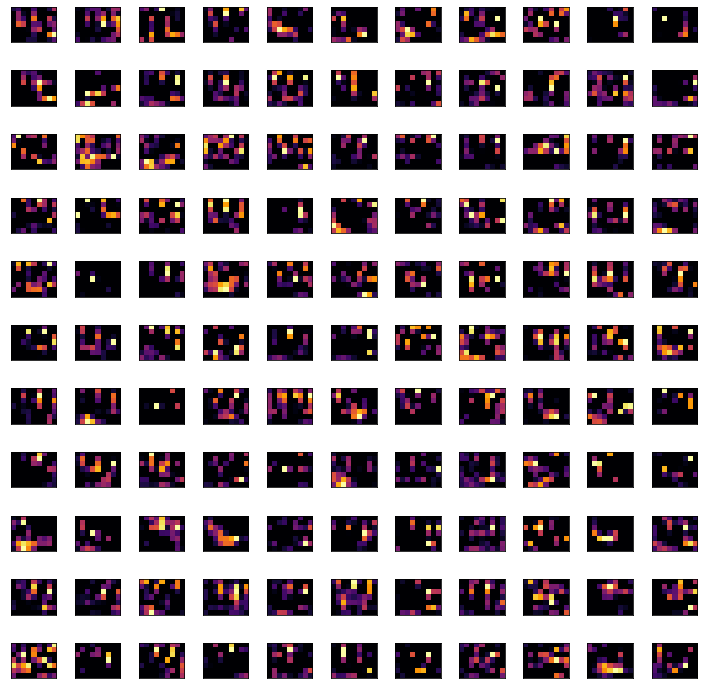

<Figure size 1440x1440 with 0 Axes>

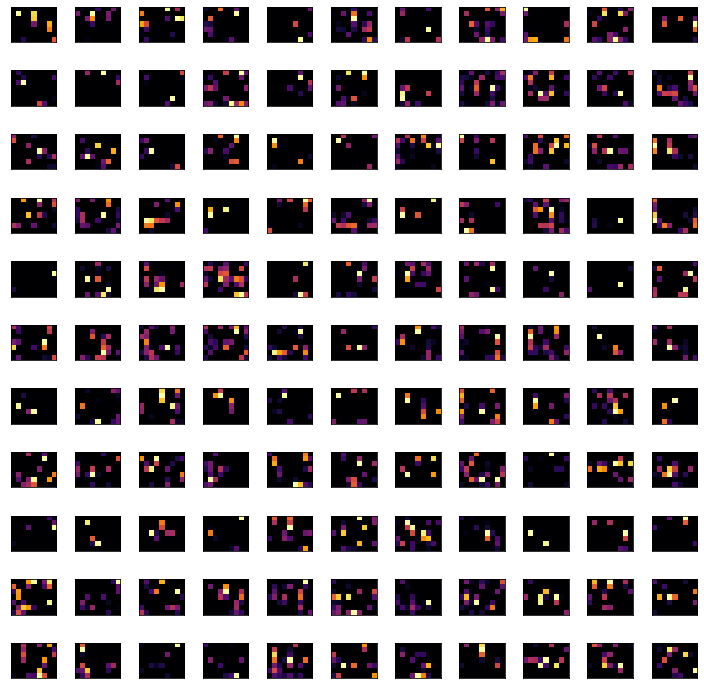

In [23]:
# Fire negative
output_filters(IMG_PATH=os.path.join('..', 'data', 'dataset'), 
               imgname='0_2.png', 
               imgsize=(38,31), 
               PRE_TRAINED_PATH=os.path.join('..', 'pretrained_models'), 
               weightsFile='ROS_ORtest_default_final_model_weights.h5',
               modeldims=(38,31,1), 
               layersidx=[0],
               figsize=(10,10),
               save=True, 
               OUTPATH='', 
               filename='featureMap',
               cmap='inferno')

## Fire

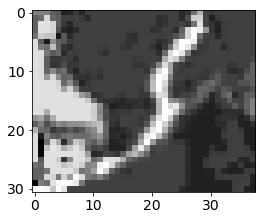

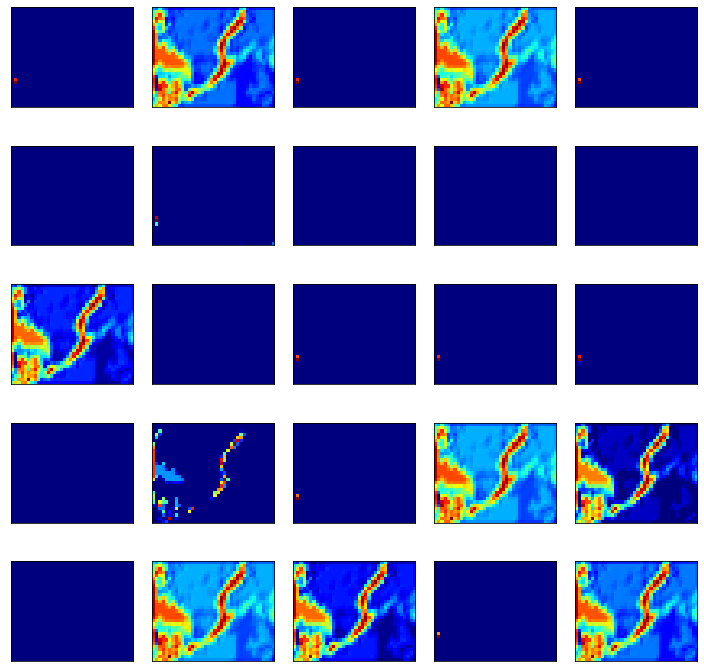

<Figure size 1440x1440 with 0 Axes>

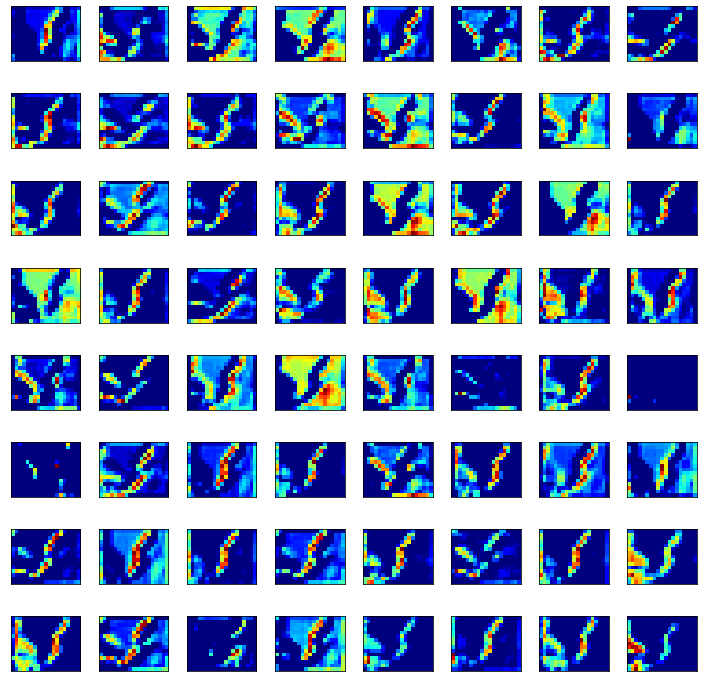

<Figure size 1440x1440 with 0 Axes>

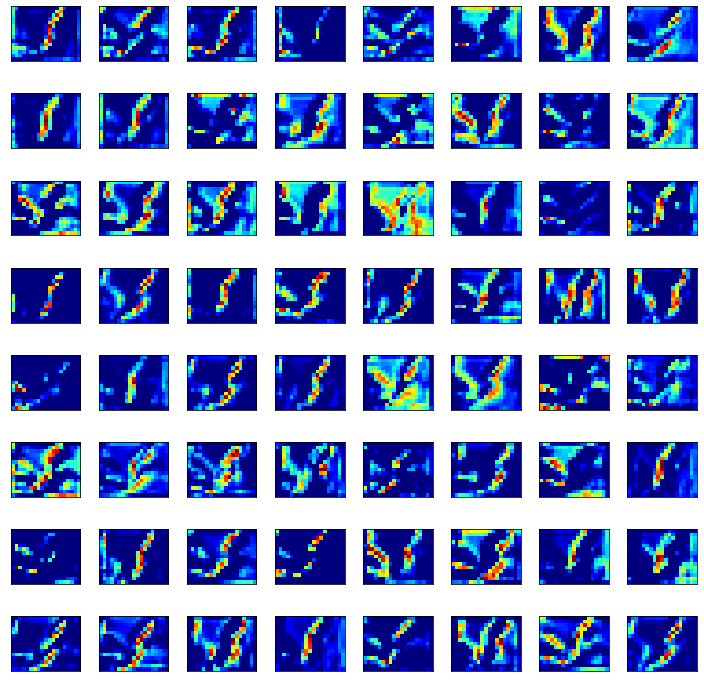

<Figure size 1440x1440 with 0 Axes>

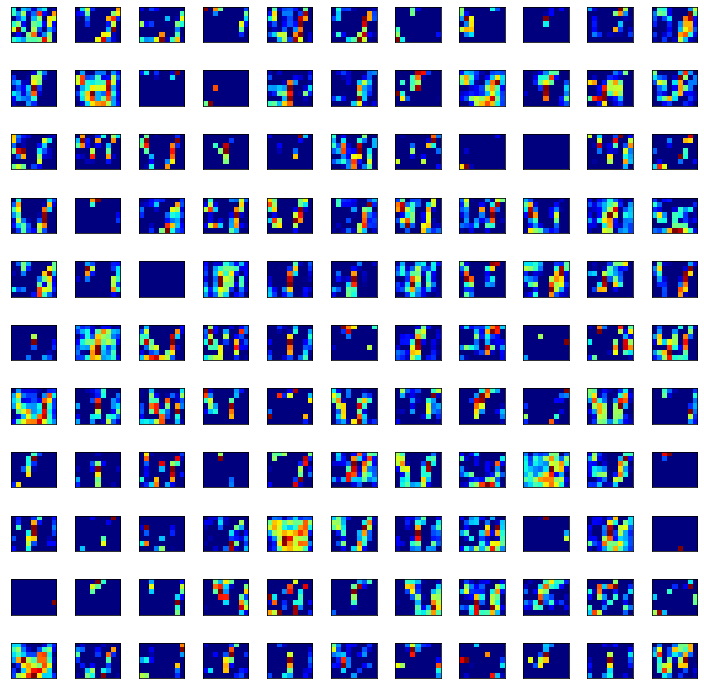

<Figure size 1440x1440 with 0 Axes>

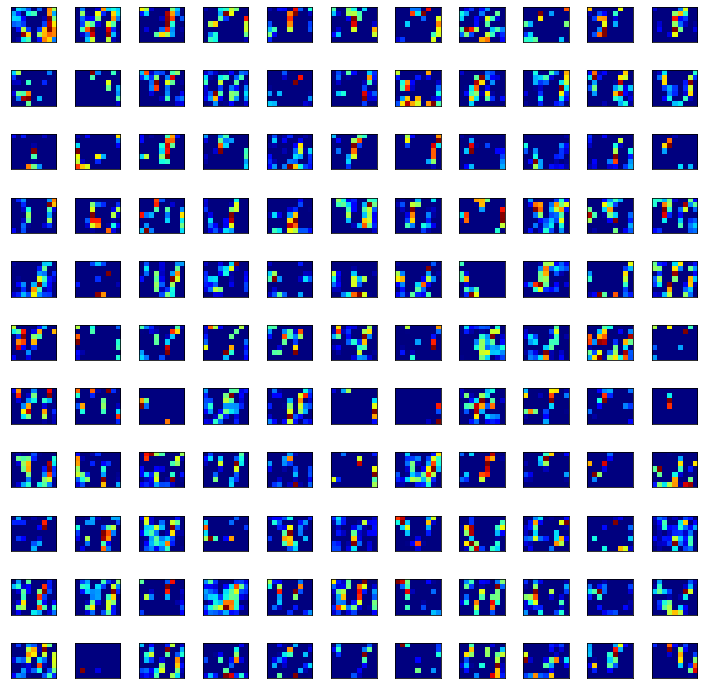

<Figure size 1440x1440 with 0 Axes>

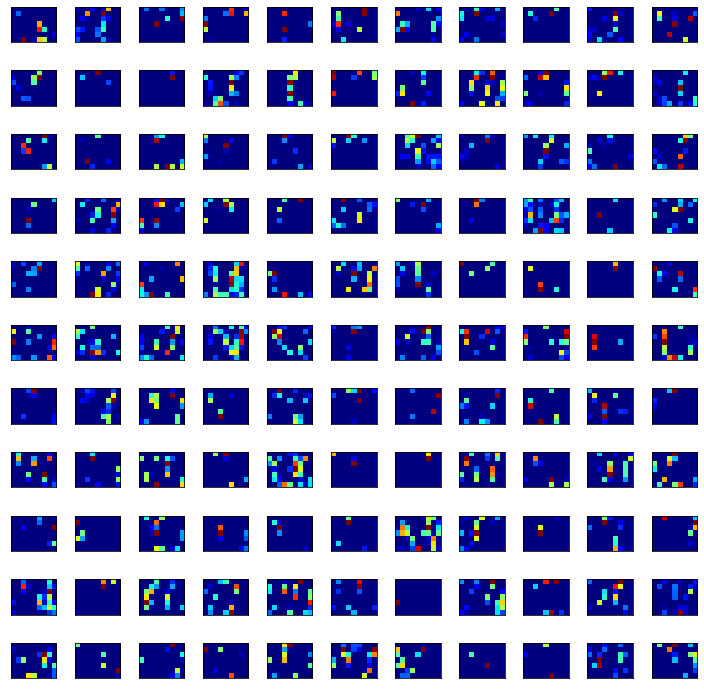

In [24]:
# Fire positive
output_filters(IMG_PATH=os.path.join('..', 'data', 'dataset'), 
               imgname='1_11212.png', 
               imgsize=(38,31), 
               PRE_TRAINED_PATH=os.path.join('..', 'pretrained_models'), 
               weightsFile='ROS_ORtest_default_final_model_weights.h5',
               modeldims=(38,31,1), 
               layersidx=[0],
               figsize=(10,10),
               save=True, 
               OUTPATH='', 
               filename='featureMap_jet',
               cmap='jet')